In [1]:
# PREDICTION FOR UTAH FROM CAMS GLOBAL DATA 

def utah_pollutant_prediction_from_cams_global_data(date: str, timestamp: str, lead_hours: int, region_tag: str = "global"):
    import gc, pickle
    from pathlib import Path
    import numpy as np
    import torch
    import xarray as xr
    import pandas as pd
    from aurora import Batch, Metadata, AuroraAirPollution

    # ------------------ paths ------------------
    download_path = Path("~/downloads/cams").expanduser()
    surf_path = download_path / f"{date}_{timestamp}_cams_{lead_hours}h_forecast_{region_tag}-surface-level.nc"
    atmo_path = download_path / f"{date}_{timestamp}_cams_{lead_hours}h_forecast_{region_tag}-atmospheric.nc"
    static_path = download_path / "aurora-0.4-air-pollution-static.pickle"

    out_dir = Path("./predictions")
    out_dir.mkdir(parents=True, exist_ok=True)
    csv_path = out_dir / f"pollutant_prediction_{date}_{timestamp}_{lead_hours}h.csv"

    UTAH_BBOX = dict(lat_min=37.0, lat_max=42.1, lon_min=245.9, lon_max=251.0)
    BBOX = UTAH_BBOX

    # ------------------ helpers ------------------
    def detect_lon_domain(ds_lon):
        lon_min = float(np.nanmin(ds_lon)); lon_max = float(np.nanmax(ds_lon))
        return "0_360" if lon_min >= 0 and lon_max > 180 else "-180_180"

    def to_dataset_lon(lon_vals, domain):
        arr = np.asarray(lon_vals, dtype=float)
        if domain == "0_360":
            arr = arr % 360.0
            arr = np.where(arr < 0, arr + 360.0, arr)
        else:
            arr = ((arr + 180.0) % 360.0) - 180.0
        return float(arr) if np.ndim(lon_vals) == 0 else arr

    def ensure_model_orientation(ds):
        if ds.longitude.size >= 2 and not np.all(np.diff(ds.longitude.values) > 0):
            ds = ds.isel(longitude=np.argsort(ds.longitude.values))
        if ds.latitude.size >= 2 and not np.all(np.diff(ds.latitude.values) < 0):
            ds = ds.isel(latitude=slice(None, None, -1))
        return ds

    def slice_bbox(ds, bbox):
        lat = ds.latitude; lon = ds.longitude
        domain = detect_lon_domain(lon.values)
        lon_min_ds, lon_max_ds = to_dataset_lon([bbox["lon_min"], bbox["lon_max"]], domain)
        lat_min, lat_max = bbox["lat_min"], bbox["lat_max"]
        if lat[0] > lat[-1]:
            lat_slice = slice(lat_max, lat_min)
        else:
            lat_slice = slice(lat_min, lat_max)
        lon_slice = slice(lon_min_ds, lon_max_ds)
        return ds.sel(latitude=lat_slice, longitude=lon_slice)

    def trim_to_patch_multiple(ds, patch_size):
        h, w = ds.sizes["latitude"], ds.sizes["longitude"]
        Hc = (h // patch_size) * patch_size
        Wc = (w // patch_size) * patch_size
        if (Hc, Wc) != (h, w):
            ds = ds.isel(latitude=slice(0, Hc), longitude=slice(0, Wc))
        return ds

    # ------------------ static + datasets ------------------
    with open(static_path, "rb") as f:
        static_vars_full = pickle.load(f)

    surf_all = xr.open_dataset(surf_path, engine="netcdf4", decode_timedelta=True)
    atmo_all = xr.open_dataset(atmo_path, engine="netcdf4", decode_timedelta=True)

    if "forecast_period" in surf_all.dims:
        surf_all = surf_all.rename({"forecast_period": "time"})
    if "forecast_period" in atmo_all.dims:
        atmo_all = atmo_all.rename({"forecast_period": "time"})

    surf_all = ensure_model_orientation(slice_bbox(surf_all, BBOX))
    atmo_all = ensure_model_orientation(slice_bbox(atmo_all, BBOX))

    # model
    model = AuroraAirPollution()
    model.load_checkpoint()
    model.eval()
    ps = int(model.patch_size)

    surf_all = trim_to_patch_multiple(surf_all, ps)
    atmo_all = trim_to_patch_multiple(atmo_all, ps)

    # time mapping
    surf_periods = surf_all["time"].values
    atmo_periods = atmo_all["time"].values
    atmo_for_surf_idx = np.searchsorted(atmo_periods, surf_periods, side="right") - 1
    atmo_for_surf_idx = np.clip(atmo_for_surf_idx, 0, len(atmo_periods) - 1)
    print("Surface steps:", len(surf_periods), "Atmos steps:", len(atmo_periods))

    # static slice
    lat = surf_all.latitude.values
    lon = surf_all.longitude.values
    static_vars_tile = {
        k: (v[:, :len(lat), :len(lon)] if v.ndim == 3 else v[:len(lat), :len(lon)])
        for k, v in static_vars_full.items() if v.ndim in (2, 3)
    }

    if "forecast_reference_time" in surf_all:
        fc_ref = pd.to_datetime(surf_all["forecast_reference_time"].values[0])
    else:
        fc_ref = pd.Timestamp("2025-10-20T00:00Z")

    # ------------------ main loop ------------------
    frames = []
    for surf_idx, atmos_idx in enumerate(atmo_for_surf_idx):
        if surf_idx == 0 or atmos_idx < 0:
            continue

        print(f"Processing hour {surf_idx}/{len(surf_periods)-1}")

        surf_prev = surf_all.isel(time=surf_idx - 1)
        surf_curr = surf_all.isel(time=surf_idx)
        atmo_prev = atmo_all.isel(time=atmos_idx - 1 if atmos_idx > 0 else 0)
        atmo_curr = atmo_all.isel(time=atmos_idx)

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ---- surface vars (1,2,H,W) ----
        surf_vars = {}
        for k, var in {
            "2t": "t2m", "10u": "u10", "10v": "v10", "msl": "msl",
            "pm1": "pm1", "pm2p5": "pm2p5", "pm10": "pm10",
            "tcco": "tcco", "tc_no": "tc_no", "tcno2": "tcno2",
            "gtco3": "gtco3", "tcso2": "tcso2"
        }.items():
            a = np.asarray(surf_prev[var].values)
            b = np.asarray(surf_curr[var].values)
            if a.ndim == 3: a = a[0]
            if b.ndim == 3: b = b[0]
            surf_vars[k] = torch.from_numpy(np.stack([a, b], axis=0)[None].astype(np.float32))

        # ---- atmospheric vars (1,2,L,H,W) ----
        atmos_vars = {}
        for k, var in {
            "t": "t", "u": "u", "v": "v", "q": "q", "z": "z",
            "co": "co", "no": "no", "no2": "no2", "go3": "go3", "so2": "so2"
        }.items():
            arr_prev = np.asarray(atmo_prev[var].values)
            arr_curr = np.asarray(atmo_curr[var].values)
            if arr_prev.ndim == 4:  # (time,L,H,W)
                arr_prev = arr_prev[0]
                arr_curr = arr_curr[0]
            assert arr_prev.ndim == 3, f"{var} expected 3D (L,H,W)"
            atmos_vars[k] = torch.from_numpy(np.stack([arr_prev, arr_curr], axis=0)[None].astype(np.float32))

        # metadata
        abs_time = fc_ref + pd.to_timedelta(surf_curr.time.values)
        batch = Batch(
            surf_vars=surf_vars,
            static_vars={k: torch.from_numpy(v) for k, v in static_vars_tile.items()},
            atmos_vars=atmos_vars,
            metadata=Metadata(
                lat=torch.from_numpy(atmo_curr.latitude.values),
                lon=torch.from_numpy(atmo_curr.longitude.values),
                time=(pd.Timestamp(abs_time).to_pydatetime(),),
                atmos_levels=tuple(int(x) for x in atmo_curr.pressure_level.values),
            ),
        )

        with torch.inference_mode():
            pred = model(batch)

        # ---------------- OUTPUT EXTRACTION ----------------
        lat_out = atmo_curr.latitude.values
        lon_out = atmo_curr.longitude.values
        flip_lat = lat_out[0] > lat_out[-1]

        def get_pred(name, scale=1.0):
            arr = pred.surf_vars[name][0, 0].cpu().numpy().astype(np.float32)
            if flip_lat: arr = arr[::-1, :]
            return arr * scale

        def get_curr_surf(name, scale=1.0):
            arr = surf_curr[name].values
            if arr.ndim == 3: arr = arr[0]
            if flip_lat: arr = arr[::-1, :]
            return arr * scale

        pm1  = get_pred("pm1",  1e9)
        pm25 = get_pred("pm2p5",1e9)
        pm10 = get_pred("pm10", 1e9)
        co   = get_pred("tcco")
        no   = get_pred("tc_no")
        no2  = get_pred("tcno2")
        o3   = get_pred("gtco3")
        so2  = get_pred("tcso2")

        LON2D, LAT2D = np.meshgrid(lon_out, lat_out)

        frame = pd.DataFrame({
            "timestamp": pd.Timestamp(abs_time),
            "latitude": LAT2D.ravel(),
            "longitude": LON2D.ravel(),
            "pm1_ugm3": pm1.ravel(),
            "pm2p5_ugm3": pm25.ravel(),
            "pm10_ugm3": pm10.ravel(),
            "co": co.ravel(),
            "no": no.ravel(),
            "no2": no2.ravel(),
            "o3": o3.ravel(),
            "so2": so2.ravel(),
        })

        frames.append(frame)

    # ------------------ save ------------------
    df = pd.concat(frames, ignore_index=True)
    df.to_csv(csv_path, index=False)
    print(f"\nSaved hourly predictions with all surface variables to {csv_path}")

utah_pollutant_prediction_from_cams_global_data("2025-10-20","0000", 24)


/uufs/chpc.utah.edu/common/home/u1494915/stream-simulation-ebus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1449953/1167133494.py:68: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  static_vars_full = pickle.load(f)


Surface steps: 25 Atmos steps: 9
Processing hour 1/24
Processing hour 2/24
Processing hour 3/24
Processing hour 4/24
Processing hour 5/24
Processing hour 6/24
Processing hour 7/24
Processing hour 8/24
Processing hour 9/24
Processing hour 10/24
Processing hour 11/24
Processing hour 12/24
Processing hour 13/24
Processing hour 14/24
Processing hour 15/24
Processing hour 16/24
Processing hour 17/24
Processing hour 18/24
Processing hour 19/24
Processing hour 20/24
Processing hour 21/24
Processing hour 22/24
Processing hour 23/24
Processing hour 24/24

Saved hourly predictions with all surface variables to predictions/pollutant_prediction_2025-10-20_0000_24h.csv


/tmp/ipykernel_1449953/647927286.py:53: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")


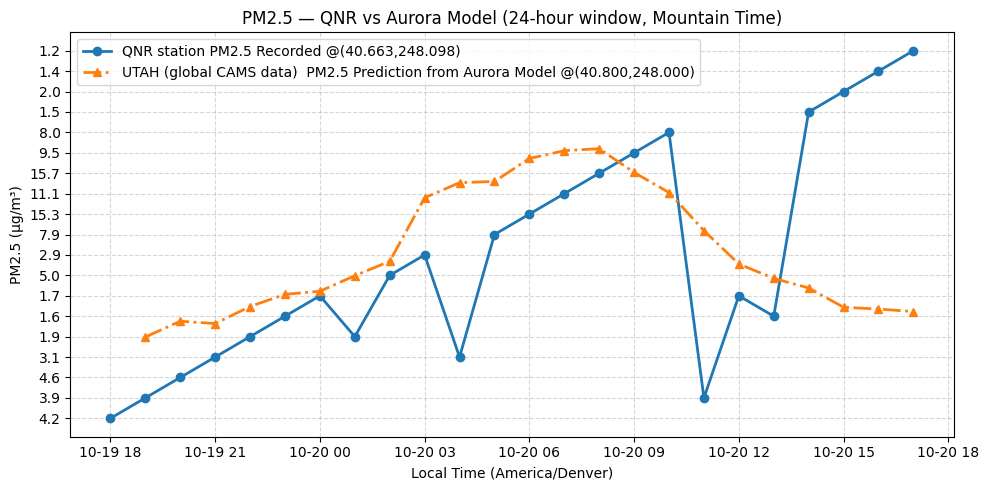

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- file paths (edit if needed) ---
station_csv = "./data/QNR.2025-10-21.csv"
new_csv     = "./predictions/pollutant_prediction_utah_hourly_full.csv"

# --- QNR station location ---
site_lat = 40.66284
site_lon = -111.90180
site_lon_0360 = (site_lon + 360.0) if site_lon < 0 else site_lon  # 248.09820

# ------------------ LOAD OBS ------------------
df_obs = pd.read_csv(
    station_csv,
    comment="#",
    skip_blank_lines=True,
    on_bad_lines="skip"
)
df_obs = df_obs[df_obs["Date_Time"].notna()]
df_obs["timestamp"] = pd.to_datetime(df_obs["Date_Time"], utc=True)
df_obs_ts = df_obs[["timestamp", "PM_25_concentration_set_1"]].rename(
    columns={"PM_25_concentration_set_1": "pm2p5_ugm3"}
)

# ------------------ LOAD MODEL FILES ------------------
df_new    = pd.read_csv(new_csv)

df_new["time"] = pd.to_datetime(df_new["time"], utc=True)

# --- choose the 24h window ---
day0  = df_obs["timestamp"].dt.floor("D").min()
start = day0
end   = day0 + pd.Timedelta(hours=23)

df_obs_24    = df_obs_ts[(df_obs_ts["timestamp"] >= start) & (df_obs_ts["timestamp"] <= end)].copy()
df_new_24    = df_new[(df_new["time"] >= start) & (df_new["time"] <= end)].copy()

# ------------------ NEAREST GRID POINTS ------------------
def nearest_point(df, lat_col, lon_col, val_col):
    lat_vals = df[lat_col].unique()
    lon_vals = df[lon_col].unique()
    lat_near = lat_vals[np.abs(lat_vals - site_lat).argmin()]
    lon_near = lon_vals[np.abs(lon_vals - site_lon_0360).argmin()]
    df_pt = df[(np.isclose(df[lat_col], lat_near)) & (np.isclose(df[lon_col], lon_near))]
    df_ts = df_pt.groupby("timestamp" if "timestamp" in df_pt else "time", as_index=False)[val_col].mean()
    return df_ts, lat_near, lon_near

df_new_ts, lat_n, lon_n = nearest_point(df_new_24, "latitude", "longitude", "pm2p5_ugm3")

# ------------------ ALIGN ON HOURLY INDEX ------------------
hourly_idx = pd.date_range(start=start, end=end, freq="H", tz="UTC")
obs_series = df_obs_24.set_index("timestamp").reindex(hourly_idx)["pm2p5_ugm3"]
new_series = df_new_ts.set_index("time").reindex(hourly_idx)["pm2p5_ugm3"]

# ------------------ CONVERT TO MOUNTAIN TIME ------------------
mountain_tz = "America/Denver"
hourly_idx_mt = hourly_idx.tz_convert(mountain_tz)
obs_series.index = hourly_idx_mt
new_series.index = hourly_idx_mt

# ------------------ PLOT ------------------
plt.figure(figsize=(10, 5))
plt.plot(hourly_idx_mt, obs_series, "o-", label=f"QNR station PM2.5 Recorded @({site_lat:.3f},{site_lon+360:.3f})", linewidth=2)
plt.plot(hourly_idx_mt, new_series, "^-.", label=f"UTAH (global CAMS data)  PM2.5 Prediction from Aurora Model @({lat_n:.3f},{lon_n:.3f})", linewidth=2)

plt.xlabel("Local Time (America/Denver)")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("PM2.5 — QNR vs Aurora Model (24-hour window, Mountain Time)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
